In [1]:
from init_nb import init_notebook
config = init_notebook()

from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import numpy as np
import seaborn as sns
from nilearn import plotting
import nibabel as nib
import itertools

from bold_dementia.connectivity import Atlas, group_by_networks, plot_matrix, reshape_pvalues
from bold_dementia.utils.iterables import unique

ATLAS = "schaeffer"
SOFT = False
ALPHA = config["alpha"]
PREFIX = "sex-balanced"

In [2]:
atlas = Atlas.from_name(ATLAS, soft=SOFT)
coords = atlas.get_coords()

In [3]:
matrices_path = Path(
    f"{config['output_dir']}/connectivity/atlas-{ATLAS}_{PREFIX}_strategy-high_pass-motion-wm_csf-global_signal"
)
AD_matrices = joblib.load(matrices_path / "AD.joblib")
control_matrices = joblib.load(matrices_path / "control.joblib")
fdrmat = joblib.load(matrices_path / "fdr_mat.joblib")
tstats = joblib.load(matrices_path / "tstats.joblib")


n_AD = AD_matrices.shape[0]
n_controls = control_matrices.shape[0]

atlas = Atlas.from_name(ATLAS, soft=SOFT)
n_regions = len(atlas.labels)

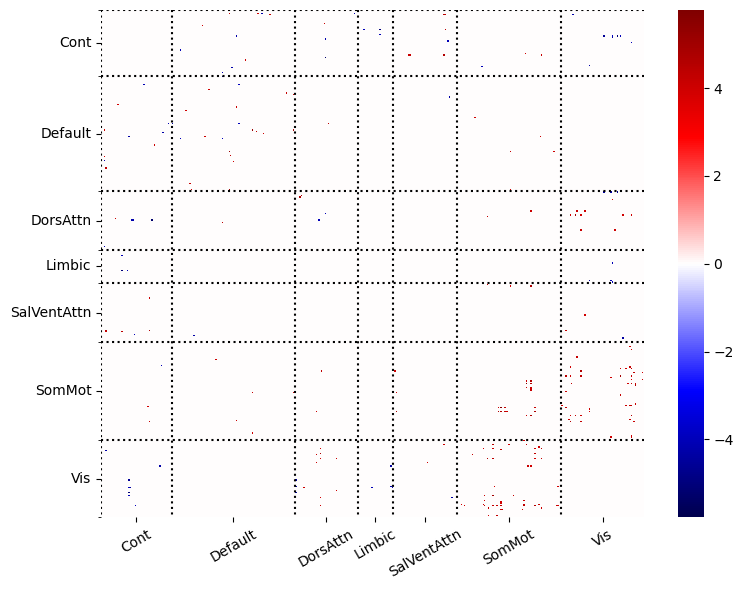

In [4]:
thresholded_t = tstats * np.where(fdrmat < ALPHA, 1, 0)
plot_matrix(thresholded_t, atlas, True)
plt.show()

In [10]:
def group_by_networks(macro_labels):
    networks = np.array(macro_labels)
    sort_index = np.argsort(networks)

    ticks = []
    lbls = []
    prev_label = None
    for i, label in enumerate(networks[sort_index]):
        if label != prev_label:
            print(label)
            ticks.append(i)
            lbls.append(label)
            prev_label = label

    ticks.append(i+1)
    return ticks, sort_index

In [19]:
thresholded_t.shape

(400, 400)

In [21]:
diagval = thresholded_t[list(range(400)), list(range(400))]
diagval.shape

(400,)

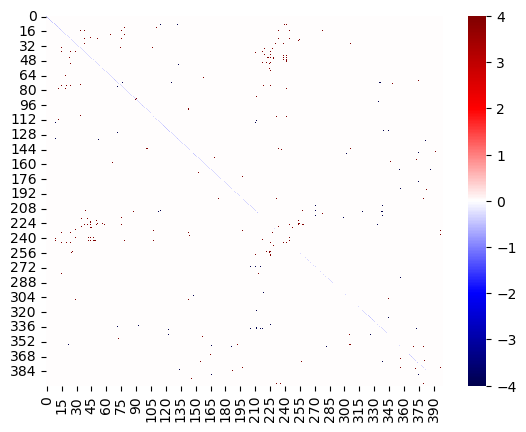

<Axes: >

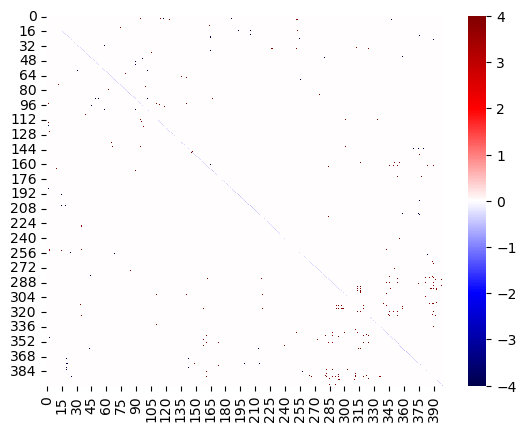

In [15]:
sns.heatmap(thresholded_t, vmin=-4, vmax=4, cmap="seismic")
plt.show()
sns.heatmap(block_mat, vmin=-4, vmax=4, cmap="seismic")

In [12]:
ticks, sort_index = group_by_networks(atlas.macro_labels)
block_mat = thresholded_t[np.ix_(sort_index, sort_index)]
ticks

Cont
Default
DorsAttn
Limbic
SalVentAttn
SomMot
Vis


[0, 52, 143, 189, 215, 262, 339, 400]

In [23]:
unique_m = sorted(tuple(unique(atlas.macro_labels)))
network_to_idx = pd.Series(dict(zip(
    unique_m,
    itertools.pairwise(ticks)
)))
network_to_idx

Cont              (0, 52)
Default         (52, 143)
DorsAttn       (143, 189)
Limbic         (189, 215)
SalVentAttn    (215, 262)
SomMot         (262, 339)
Vis            (339, 400)
dtype: object

In [24]:
def block_count(matrix, network_to_idx):
    for network_a, network_b in itertools.combinations(network_to_idx.index, 2):
            loc_a, loc_b = network_to_idx[network_a], network_to_idx[network_b]
            n_observed_edges = np.count_nonzero(matrix[loc_a[0]:loc_a[1], loc_b[0]:loc_b[1]])
            yield network_a, network_b, n_observed_edges

In [25]:
count_vector = block_count(block_mat, network_to_idx)
mat = reshape_pvalues([counts[2] for counts in count_vector])

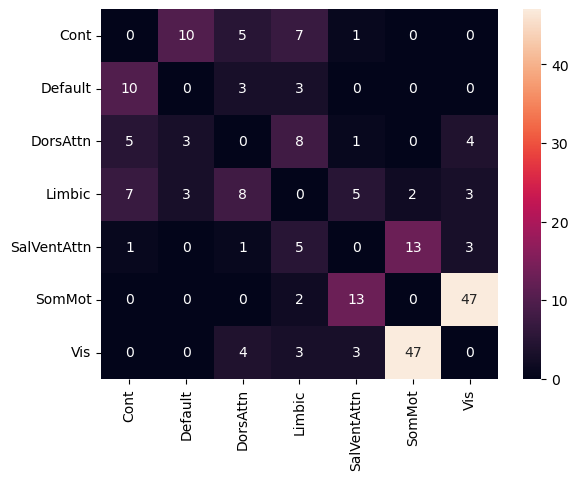

In [26]:
heat_kwargs = {"xticklabels":unique_m, "yticklabels":unique_m}
sns.heatmap(mat, annot=True, **heat_kwargs)
plt.show()

In [16]:
view = plotting.view_connectome(thresholded_t, coords, edge_threshold="90%")
view.open_in_browser()

In [17]:
# Atlas visualisation : stack ROI on 4th axis
output_path = Path(config["output_dir"]) / "atlases" / f"{atlas.name}_overlay.nii.gz"

network_images = []

networks = np.array(atlas.macro_labels)
maps = nib.load(atlas.maps)
img = maps.get_fdata()

for network in unique(atlas.macro_labels):
    
    network_colors = list(np.where(networks == network)[0])
    
    print(f"{network} : {len(network_colors)} regions")

    network_img = np.where(np.isin(img, network_colors), 1., 0.)
    bg_mask = np.where(img == 0, 0, 1)
    network_images.append(network_img * bg_mask)

output_img = np.stack(network_images, axis=-1)
network_maps = nib.Nifti1Image(output_img, maps.affine)
nib.save(network_maps, output_path)
    

Vis : 61 regions
SomMot : 77 regions
DorsAttn : 46 regions
SalVentAttn : 47 regions
Limbic : 26 regions
Cont : 52 regions
Default : 91 regions
